In [1]:
import json

In [2]:
# load json file to extend the node info
with open("../data/aggregated_data.json") as jr:
    cve_json = json.load(jr)



In [3]:
order = 0
for key, value in cve_json.items():
    while order >= 10:
        print(key)
        print(value)
        order += 1
        

# check cves families with cwes

- one cve can potentially map to multiple cwes, cwe can be used to identify cves belong to same families

- we explore the following questions:

  - how many groups / families exist in this dataset
  - whether the same group of cves tend to infect similar software or diverse software, what is the relationships between specific familiy of cves and clusters of packages?
  - whether same cve can infect different packages


In [4]:
# cve as the key, infected packages / releases as the values
cve_pack_dict = {}

# cwe as the key, the packages / releases share the same cwe as the values
cwe_pack_dict = {}

# cwe as the key, cves as the values
cwe_cve_dict = {}

In [5]:
import ast

def parse_cwe_ids(data_dict):
    # Try loading the cwe_ids as a list
    try:
        cwe_ids_str = data_dict["cwe_ids"]
        if isinstance(cwe_ids_str, str) and cwe_ids_str != "UNKNOWN":
            cwe_ids_str = cwe_ids_str.replace('CWE-', '"CWE-')
            cwe_ids_str = cwe_ids_str.replace(',', '",')
            cwe_ids_str = cwe_ids_str.replace(']', '"]')
            # Now safely parse the string as a list
            data_dict['cwe_ids'] = ast.literal_eval(cwe_ids_str)
            
    except (ValueError, SyntaxError):
        # If it fails, print an error (optional) or handle the error
        data_dict['cwe_ids'] = []  # Set to empty list if there's an error

    return data_dict


In [6]:
from collections import defaultdict


merged_data = defaultdict(list)


for pack, cve_info_list in cve_json.items():
    # Extract the package name by removing the release version at the end
    package_name = ':'.join(pack.split(':')[:-1])
    
    # Append vulnerabilities to the package in the merged_data dictionary
    merged_data[package_name].extend(cve_info_list)
                

In [7]:
print(list(merged_data.values())[:10])

[[{'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL', 'name': 'CVE-2015-8103', 'cwe_ids': '[CWE-502]'}, {'severity': 'CRITICAL'

In [8]:
for pack, cve_info_list in merged_data.items():
    for cve_dict in cve_info_list:
        cve_name = cve_dict["name"]
        # record cve dict information
        if cve_name not in cve_pack_dict.keys():
            cve_pack_dict[cve_name] = []
            cve_pack_dict[cve_name].append(pack)
        else:
            cve_pack_dict[cve_name].append(pack)
        # record the cwe information
        cve_dict = parse_cwe_ids(cve_dict)
        cwe_name_list = cve_dict["cwe_ids"]
        
        for cwe in cwe_name_list:
            if cwe not in cwe_pack_dict.keys():
                cwe_pack_dict[cwe] = []
                cwe_pack_dict[cwe].append(pack)
            else:
                cwe_pack_dict[cwe].append(pack)
            # record the cwe and cve info
            if cwe not in cwe_cve_dict.keys():
                cwe_cve_dict[cwe] = []
                cwe_cve_dict[cwe].append(cve_name)
            else:
                cwe_cve_dict[cwe].append(cve_name)
                

### Analyze cve_pack_dict
Check the packages with most cves

In [9]:
from collections import Counter

# Assume your dictionary is called cve_dict
package_counter = Counter([pkg for pkg_list in cve_pack_dict.values() for pkg in pkg_list])

# Get basic statistics
total_unique_packages = len(package_counter)

most_common_packages = package_counter.most_common(6)

cve_per_package = {pkg: count for pkg, count in package_counter.items()}

print(f"Total unique packages: {total_unique_packages}")
print(f"Top 50 packages by number of CVEs: {most_common_packages}")

Total unique packages: 2105
Top 50 packages by number of CVEs: [('org.jenkins-ci.main:jenkins-core', 91508), ('io.undertow:undertow-core', 7583), ('com.fasterxml.jackson.core:jackson-databind', 6429), ('org.keycloak:keycloak-core', 6026), ('org.keycloak:keycloak-services', 5084), ('org.elasticsearch:elasticsearch', 4616)]


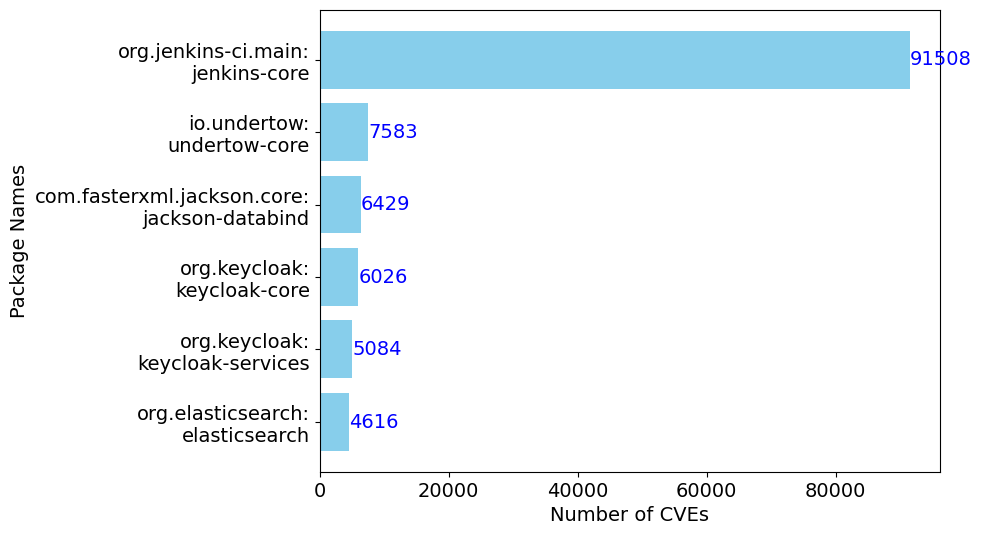

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract the package names and the number of CVEs
packages = [":\n".join(pkg.split(":")[-2:]) for pkg, count in most_common_packages]
counts = [count for pkg, count in most_common_packages]

packages, counts = zip(*sorted(zip(packages, counts), key=lambda x: x[1]))

# Step 2: Create a bar plot with package names on the x-axis and CVE counts on the y-axis
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.barh(packages, counts, color='skyblue')  # Use barh() to create a horizontal bar plot

# Step 3: Add titles and labels
plt.xlabel("Number of CVEs", fontsize=14)
plt.ylabel("Package Names", fontsize=14)
# plt.title("Top 10 Packages by Number of CVEs")

# Increase font size for the y-axis tick labels (package names)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Display the values on the left of the bars
for i, v in enumerate(counts):
    plt.text(v + 0.5, i, str(v), color='blue', va='center',fontsize=14)

# Step 4: Show the plot
plt.show()


### Analyze the distribution of number of packages per CVE

In [25]:
# Assuming your dictionary is called `cve_dict`
cve_package_lengths = {cve: len(packages) for cve, packages in cve_pack_dict.items()}

# Optionally, convert it to a Pandas DataFrame for easier analysis
import pandas as pd

cve_df = pd.DataFrame(list(cve_package_lengths.items()), columns=['CVE', 'Package_Count'])

# Display the DataFrame
print(cve_df.head())

                            CVE  Package_Count
0                 CVE-2015-8103            292
1  BIT-elasticsearch-2023-46674            275
2                 CVE-2015-8031            344
3                CVE-2022-29546             38
4                CVE-2022-28366              4


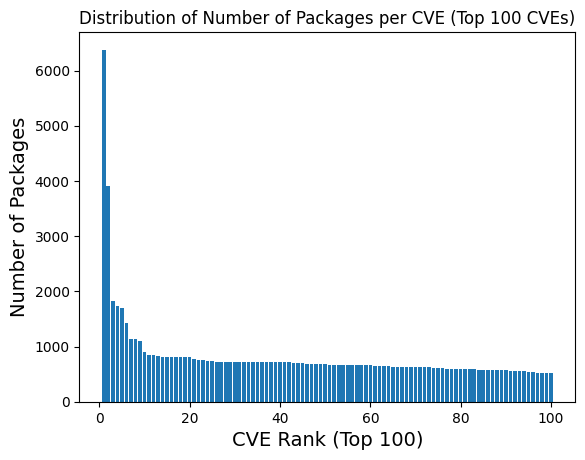

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.pyplot as plt

# Assume your dictionary is called cve_dict

# Step 1: Calculate the length of each list of packages for each CVE
cve_package_lengths = {cve: len(packages) for cve, packages in cve_pack_dict.items()}

# Step 2: Sort the dictionary by the length of the package lists (descending order)
sorted_cve_lengths = sorted(cve_package_lengths.items(), key=lambda x: x[1], reverse=True)

# Step 3: Get the top 100 CVEs based on the length of their package lists
top_100_cves = sorted_cve_lengths[:100]

# Step 4: Visualize the distribution of the number of packages for the top 100 CVEs
top_100_lengths = [length for _, length in top_100_cves]

plt.bar(range(1, 101), top_100_lengths)
plt.title("Distribution of Number of Packages per CVE (Top 100 CVEs)")
plt.xlabel("CVE Rank (Top 100)",fontsize=14)
plt.ylabel("Number of Packages",fontsize=14)
plt.show()

1
Percentage of CVE pairs with similarity score above 0.1: 0.32%
Percentage of CVE pairs with similarity score above 0.2: 0.29%
Percentage of CVE pairs with similarity score above 0.30000000000000004: 0.27%
Percentage of CVE pairs with similarity score above 0.4: 0.24%
Percentage of CVE pairs with similarity score above 0.5: 0.21%
Percentage of CVE pairs with similarity score above 0.6: 0.18%
Percentage of CVE pairs with similarity score above 0.7000000000000001: 0.15%
Percentage of CVE pairs with similarity score above 0.8: 0.11%
Percentage of CVE pairs with similarity score above 0.9: 0.06%


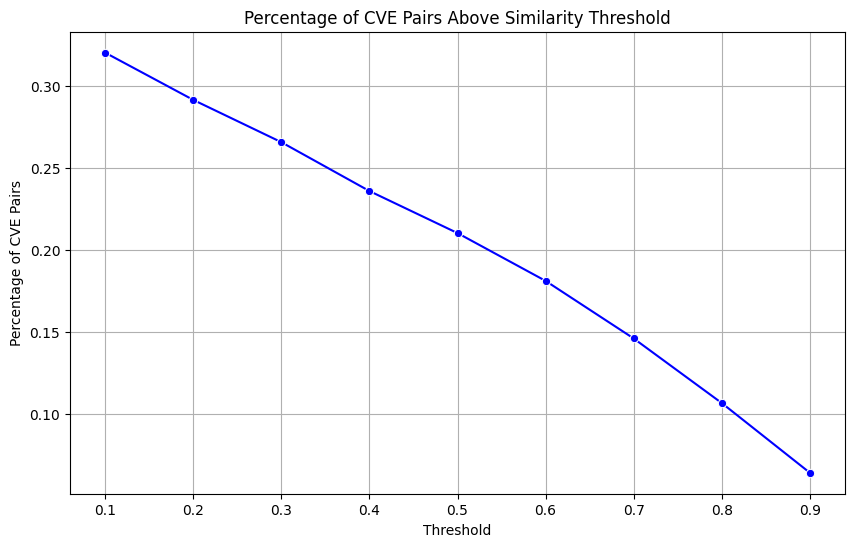

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Example: Calculate Jaccard similarity between CVEs
def jaccard_similarity(cve1, cve2, cve_dict):
    set1, set2 = set(cve_dict[cve1]), set(cve_dict[cve2])
    return len(set1 & set2) / len(set1 | set2)

print(len(cves))
# Create a list of CVEs
# Function to compute percentage of CVE pairs above a threshold
def cve_similarity_analysis(cve_pack_dict, threshold):
    cves = list(cve_pack_dict.keys())

    # Initialize a similarity matrix
    similarity_matrix = np.zeros((len(cves), len(cves)))

    # Calculate similarities and fill the matrix
    for i, cve1 in enumerate(cves):
        for j, cve2 in enumerate(cves):
            if i < j:  # Only calculate for pairs
                similarity = jaccard_similarity(cve1, cve2, cve_pack_dict)
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity  # Symmetric matrix

    # Create a DataFrame from the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=cves, columns=cves)

    # Filter based on the threshold
    filtered_df = similarity_df[similarity_df > threshold]

    # Calculate percentage of pairs above the threshold
    total_pairs = (len(cves) * (len(cves) - 1)) // 2  # Total number of possible pairs
    non_zero_pairs = (filtered_df > 0).sum().sum() // 2  # Count non-zero pairs
    percentage_above_threshold = (non_zero_pairs / total_pairs) * 100

    # Print the result
    print(f"Percentage of CVE pairs with similarity score above {threshold}: {percentage_above_threshold:.2f}%")

    # Return the percentage for further analysis
    return percentage_above_threshold

# Function to visualize the similarity thresholds
def visualize_similarity_thresholds(cve_pack_dict):
    thresholds = np.arange(0.1, 1.0, 0.1)  # Thresholds from 0.1 to 0.9
    percentages = []

    # Calculate percentages for each threshold
    for threshold in thresholds:
        percentage = cve_similarity_analysis(cve_pack_dict, threshold)
        percentages.append(percentage)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=thresholds, y=percentages, marker='o', color='b')
    plt.title('Percentage of CVE Pairs Above Similarity Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Percentage of CVE Pairs')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.show()

# Example usage (with your existing cve_pack_dict dictionary):
visualize_similarity_thresholds(cve_pack_dict)

### Analyse cwe_pack_dict

In [29]:
print(list(cwe_pack_dict.keys()))

['CWE-502', 'CWE-611', 'CWE-400', 'CWE-79', 'CWE-83', 'CWE-209', 'CWE-287', 'CWE-601', 'CWE-668', 'CWE-863', 'CWE-304', 'CWE-488', 'CWE-613', 'CWE-116', 'CWE-307', 'CWE-522', 'CWE-770', 'CWE-177', 'CWE-22', 'CWE-183', 'CWE-732', 'CWE-295', 'CWE-297', 'CWE-352', 'CWE-377', 'CWE-379', 'CWE-59', 'CWE-15', 'CWE-610', 'CWE-664', 'CWE-459', 'CWE-200', 'CWE-214', 'CWE-24', 'CWE-835', 'CWE-362', 'CWE-401', 'CWE-674', 'CWE-917', 'CWE-918', 'CWE-754', 'CWE-149', 'CWE-444', 'CWE-20', 'CWE-285', 'CWE-532', 'CWE-1188', 'CWE-119', 'CWE-639', 'CWE-74', 'CWE-94', 'CWE-526', 'CWE-270', 'CWE-345', 'CWE-862', 'CWE-248', 'CWE-89', 'CWE-148', 'CWE-279', 'CWE-434', 'CWE-384', 'CWE-284', 'CWE-670', 'CWE-269', 'CWE-81', 'CWE-117', 'CWE-640', 'CWE-80', 'CWE-288', 'CWE-837', 'CWE-75', 'CWE-346', 'CWE-625', 'CWE-290', 'CWE-347', 'CWE-358', 'CWE-90', 'CWE-922', 'CWE-306', 'CWE-1333', 'CWE-319', 'CWE-178', 'CWE-327', 'CWE-155', 'CWE-150', 'CWE-1390', 'CWE-77', 'CWE-330', 'CWE-338', 'CWE-40', 'CWE-311', 'CWE-697', 

In [23]:
from collections import Counter

# Assume your dictionary is called cve_dict
package_counter = Counter([pkg for pkg_list in cwe_pack_dict.values() for pkg in pkg_list])

# Get basic statistics
total_unique_packages = len(package_counter)
most_common_packages = package_counter.most_common(6)
cwe_per_package = {pkg: count for pkg, count in package_counter.items()}

print(f"Total unique packages: {total_unique_packages}")
print(f"Top 50 packages by number of CWEs: {most_common_packages}")

Total unique packages: 2044
Top 50 packages by number of CWEs: [('org.jenkins-ci.main:jenkins-core', 99824), ('io.undertow:undertow-core', 8377), ('org.keycloak:keycloak-core', 7876), ('org.keycloak:keycloak-services', 7688), ('com.fasterxml.jackson.core:jackson-databind', 7595), ('org.elasticsearch:elasticsearch', 5315)]


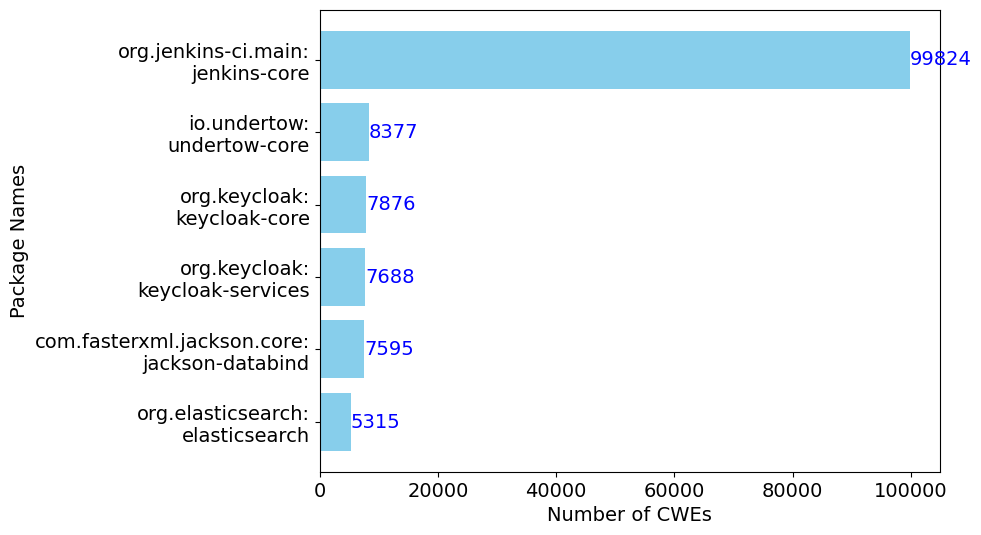

In [24]:
most_common_packages = sorted(most_common_packages, key=lambda x: x[1], reverse=False)

# Step 1: Extract the package names and the number of CVEs
packages = [":\n".join(pkg.split(":")[-2:]) for pkg, count in most_common_packages]
counts = [count for pkg, count in most_common_packages]

# Step 2: Create a bar plot with package names on the x-axis and CVE counts on the y-axis
plt.figure(figsize=(8, 6))  # Adjust the size of the plot
plt.barh(packages, counts, color='skyblue')  # Use barh() to create a horizontal bar plot

# Step 3: Add titles and labels
plt.xlabel("Number of CWEs", fontsize=14)
plt.ylabel("Package Names", fontsize=14)
# plt.title("Top 10 Packages by Number of CWEs", fontsize=16)

# Increase font size for the y-axis tick labels (package names)
plt.yticks(fontsize=14)  
plt.xticks(fontsize=14)  


# Display the values on the bars
for i, v in enumerate(counts):
    plt.text(v + 0.5, i, str(v), color='blue', va='center',fontsize=14)

# Step 4: Show the plot
plt.show()

#### Analyze the distribution of number of packages per CWE

In [32]:
# Assuming your dictionary is called `cve_dict`
cwe_package_lengths = {cwe: len(packages) for cwe, packages in cwe_pack_dict.items()}
print(len(cwe_package_lengths.keys()))
print(list(cwe_package_lengths.keys())[0])
print(list(cwe_package_lengths.keys()))
# Optionally, convert it to a Pandas DataFrame for easier analysis
import pandas as pd

cwe_df = pd.DataFrame(list(cwe_package_lengths.items()), columns=['CWE', 'Package_Count'])

# Display the DataFrame
print(cwe_df.head())

251
CWE-502
['CWE-502', 'CWE-611', 'CWE-400', 'CWE-79', 'CWE-83', 'CWE-209', 'CWE-287', 'CWE-601', 'CWE-668', 'CWE-863', 'CWE-304', 'CWE-488', 'CWE-613', 'CWE-116', 'CWE-307', 'CWE-522', 'CWE-770', 'CWE-177', 'CWE-22', 'CWE-183', 'CWE-732', 'CWE-295', 'CWE-297', 'CWE-352', 'CWE-377', 'CWE-379', 'CWE-59', 'CWE-15', 'CWE-610', 'CWE-664', 'CWE-459', 'CWE-200', 'CWE-214', 'CWE-24', 'CWE-835', 'CWE-362', 'CWE-401', 'CWE-674', 'CWE-917', 'CWE-918', 'CWE-754', 'CWE-149', 'CWE-444', 'CWE-20', 'CWE-285', 'CWE-532', 'CWE-1188', 'CWE-119', 'CWE-639', 'CWE-74', 'CWE-94', 'CWE-526', 'CWE-270', 'CWE-345', 'CWE-862', 'CWE-248', 'CWE-89', 'CWE-148', 'CWE-279', 'CWE-434', 'CWE-384', 'CWE-284', 'CWE-670', 'CWE-269', 'CWE-81', 'CWE-117', 'CWE-640', 'CWE-80', 'CWE-288', 'CWE-837', 'CWE-75', 'CWE-346', 'CWE-625', 'CWE-290', 'CWE-347', 'CWE-358', 'CWE-90', 'CWE-922', 'CWE-306', 'CWE-1333', 'CWE-319', 'CWE-178', 'CWE-327', 'CWE-155', 'CWE-150', 'CWE-1390', 'CWE-77', 'CWE-330', 'CWE-338', 'CWE-40', 'CWE-311',

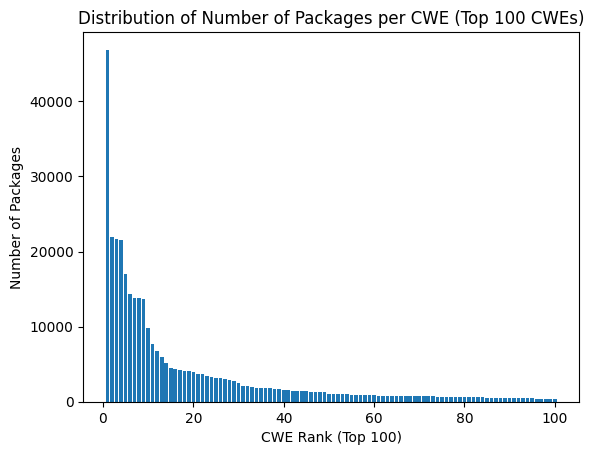

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.pyplot as plt

# Assume your dictionary is called cve_dict

# Step 1: Calculate the length of each list of packages for each CVE
cwe_package_lengths = {cwe: len(packages) for cwe, packages in cwe_pack_dict.items()}

# Step 2: Sort the dictionary by the length of the package lists (descending order)
sorted_cwe_lengths = sorted(cwe_package_lengths.items(), key=lambda x: x[1], reverse=True)

# Step 3: Get the top 100 CVEs based on the length of their package lists
top_100_cwes = sorted_cwe_lengths[:100]

# Step 4: Visualize the distribution of the number of packages for the top 100 CVEs
top_100_lengths = [length for _, length in top_100_cwes]

plt.bar(range(1, 101), top_100_lengths)
plt.title("Distribution of Number of Packages per CWE (Top 100 CWEs)")
plt.xlabel("CWE Rank (Top 100)")
plt.ylabel("Number of Packages")
plt.show()

Percentage of CVE pairs with similarity score above 0.1: 3.22%
Percentage of CVE pairs with similarity score above 0.2: 1.48%
Percentage of CVE pairs with similarity score above 0.30000000000000004: 0.95%
Percentage of CVE pairs with similarity score above 0.4: 0.66%
Percentage of CVE pairs with similarity score above 0.5: 0.48%
Percentage of CVE pairs with similarity score above 0.6: 0.38%
Percentage of CVE pairs with similarity score above 0.7000000000000001: 0.24%
Percentage of CVE pairs with similarity score above 0.8: 0.18%
Percentage of CVE pairs with similarity score above 0.9: 0.11%


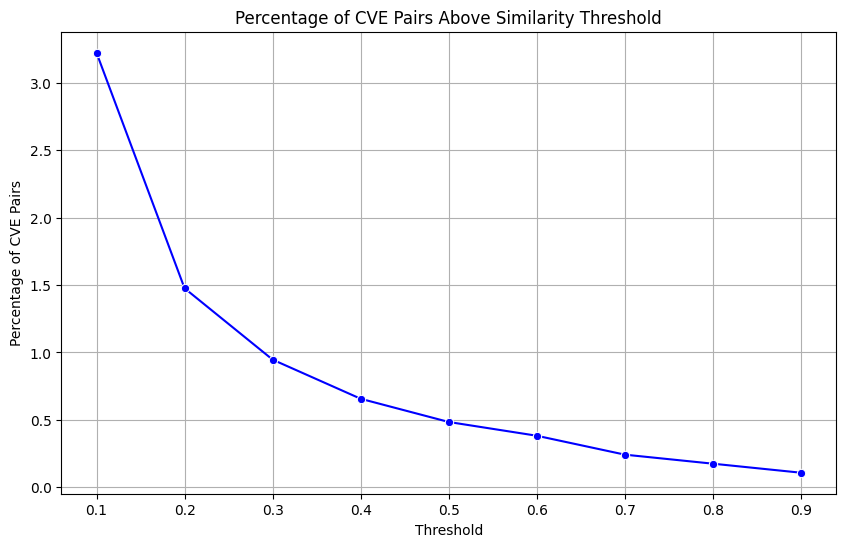

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

visualize_similarity_thresholds(cwe_pack_dict)

## Analyze cwe_cve_dict

In [40]:
from collections import Counter

cve_counter = Counter([cve for cve_list in cwe_cve_dict.values() for cve in cve_list])

# Get basic statistics
total_unique_cves = len(cve_counter)
most_common_cves = cve_counter.most_common(10)[1:]
cwv_per_cve = {cve: count for cve, count in cve_counter.items()}

print(f"Total unique cves: {total_unique_cves}")
print(f"Top 50 cves by number of CWEs: {most_common_cves}")

Total unique cves: 4211
Top 50 cves by number of CWEs: [('CVE-2023-32070', 3394), ('BIT-jenkins-2024-43044', 2208), ('CVE-2023-6835', 1817), ('BIT-jenkins-2024-43045', 1786), ('CVE-2024-45294', 1739), ('CVE-2021-44228', 1588), ('BIT-jenkins-2022-34174', 1530), ('CVE-2022-22965', 1516), ('BIT-jenkins-2022-34171', 1494)]


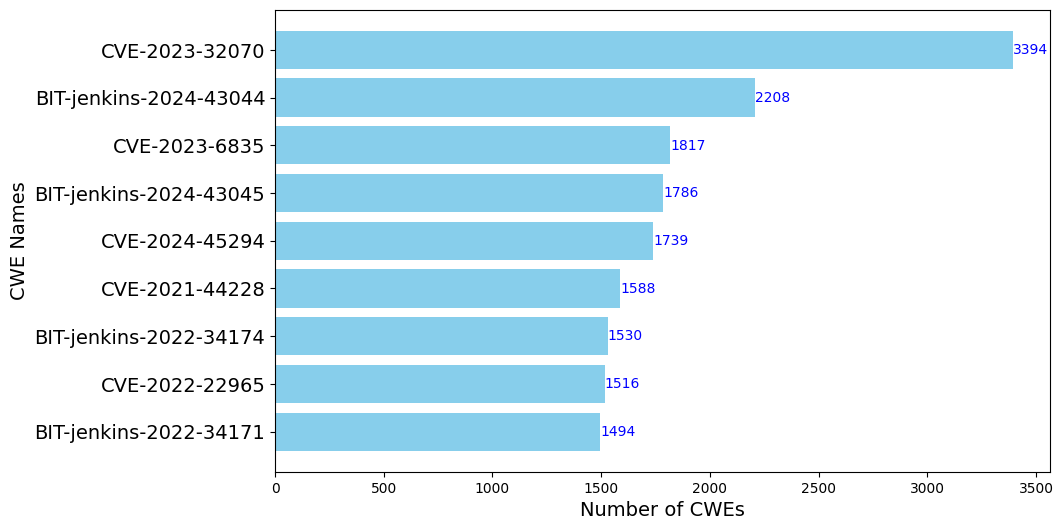

In [41]:
most_common_cves = sorted(most_common_cves, key=lambda x: x[1], reverse=False)

cves = [cve for cve, count in most_common_cves]
counts = [count for cve, count in most_common_cves]

plt.figure(figsize=(10, 6))  # Adjust the size of the plot
plt.barh(cves, counts, color='skyblue')  # Use barh() to create a horizontal bar plot

# Step 3: Add titles and labels
plt.xlabel("Number of CWEs", fontsize=14)
plt.ylabel("CWE Names", fontsize=14)
# plt.title("Top 20 CVEs by Number of CWEs", fontsize=16)

# Increase font size for the y-axis tick labels (package names)
plt.yticks(fontsize=14)  

# Display the values on the bars
for i, v in enumerate(counts):
    plt.text(v + 0.5, i, str(v), color='blue', va='center')

# Step 4: Show the plot
plt.show()

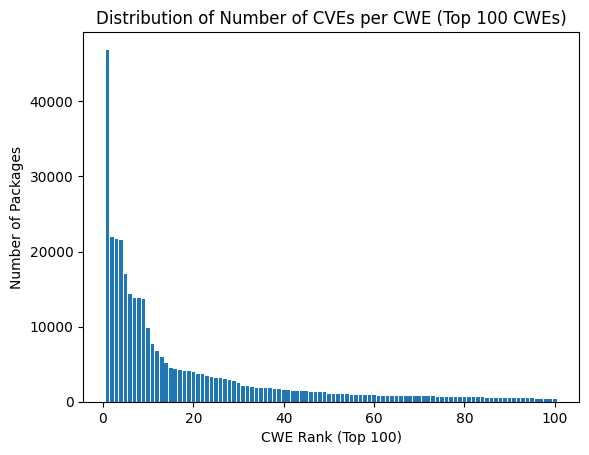

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.pyplot as plt

# Assume your dictionary is called cve_dict

cwe_cve_lengths = {cwe: len(cves) for cwe, cves in cwe_cve_dict.items()}

sorted_cwe_lengths = sorted(cwe_cve_lengths.items(), key=lambda x: x[1], reverse=True)

# Step 3: Get the top 100 CVEs based on the length of their package lists
top_100_cwes = sorted_cwe_lengths[:100]

# Step 4: Visualize the distribution of the number of packages for the top 100 CVEs
top_100_lengths = [length for _, length in top_100_cwes]

plt.bar(range(1, 101), top_100_lengths)
plt.title("Distribution of Number of CVEs per CWE (Top 100 CWEs)")
plt.xlabel("CWE Rank (Top 100)")
plt.ylabel("Number of Packages")
plt.show()

Percentage of CVE pairs with similarity score above 0.1: 0.61%
Percentage of CVE pairs with similarity score above 0.2: 0.37%
Percentage of CVE pairs with similarity score above 0.30000000000000004: 0.32%
Percentage of CVE pairs with similarity score above 0.4: 0.15%
Percentage of CVE pairs with similarity score above 0.5: 0.08%
Percentage of CVE pairs with similarity score above 0.6: 0.08%
Percentage of CVE pairs with similarity score above 0.7000000000000001: 0.08%
Percentage of CVE pairs with similarity score above 0.8: 0.08%
Percentage of CVE pairs with similarity score above 0.9: 0.08%


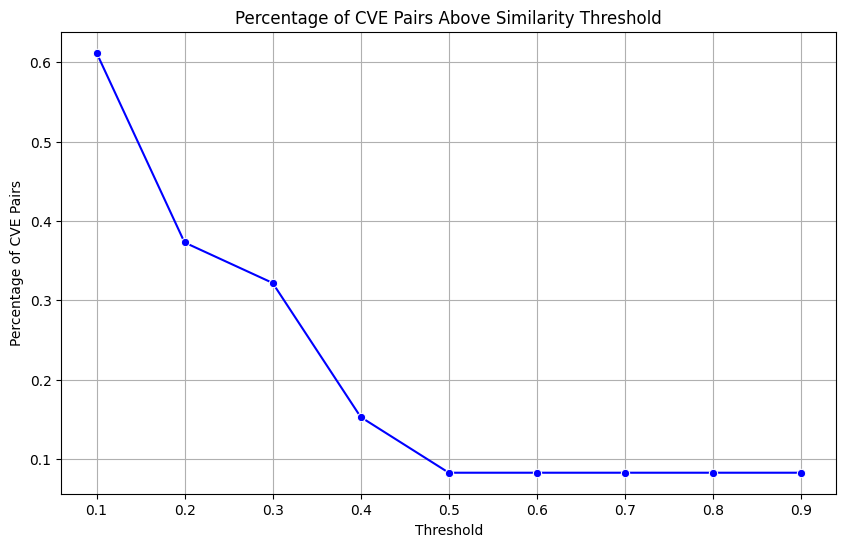

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

visualize_similarity_thresholds(cwe_cve_dict)

### Visualize three lines in one table

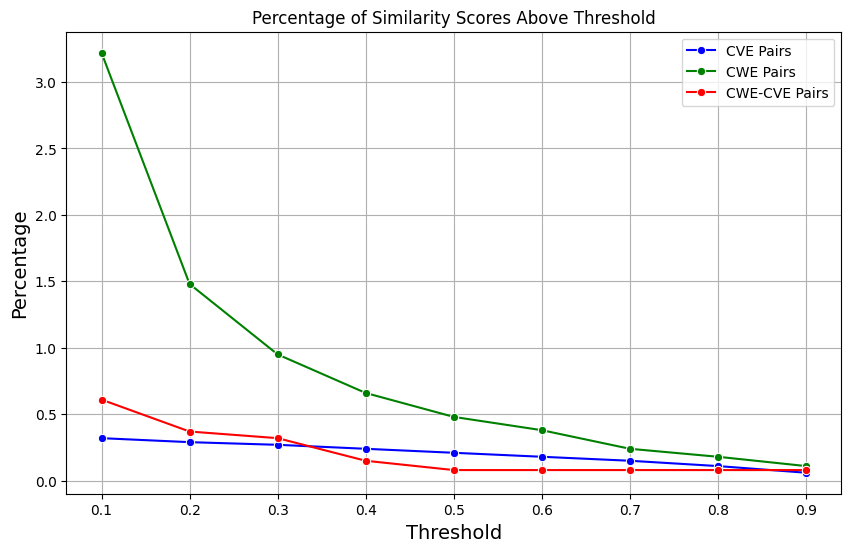

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


# Data for CVE pairs, CWE pairs, and CWE-CVE pairs
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Percentages for each dataset (from the example you provided)
cve_percentages = [0.32, 0.29, 0.27, 0.24, 0.21, 0.18, 0.15, 0.11, 0.06]
cwe_percentages = [3.22, 1.48, 0.95, 0.66, 0.48, 0.38, 0.24, 0.18, 0.11]
cwe_cve_percentages = [0.61, 0.37, 0.32, 0.15, 0.08, 0.08, 0.08, 0.08, 0.08]

# Plot the results
plt.figure(figsize=(10, 6))

# Plot CVE similarity percentages
sns.lineplot(x=thresholds, y=cve_percentages, marker='o', label='CVE Pairs', color='b')

# Plot CWE similarity percentages
sns.lineplot(x=thresholds, y=cwe_percentages, marker='o', label='CWE Pairs', color='g')

# Plot CWE-CVE similarity percentages
sns.lineplot(x=thresholds, y=cwe_cve_percentages, marker='o', label='CWE-CVE Pairs', color='r')

# Add titles and labels
plt.title('Percentage of Similarity Scores Above Threshold')
plt.xlabel('Threshold',fontsize=14)
plt.ylabel('Percentage',fontsize=14)
plt.xticks(thresholds)
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()
